In [5]:
%%shell
rm -rf ./*
gdown --id 1TfN4Zn9Jnf721o_FPV7X1KTlGZkD8k3p

Downloading...
From: https://drive.google.com/uc?id=1TfN4Zn9Jnf721o_FPV7X1KTlGZkD8k3p
To: /content/dataset.tar.gz
281MB [00:09, 30.7MB/s]


In [6]:
%%shell
tar -xf dataset.tar.gz

In [7]:
!pip install keras==2.2.5
%tensorflow_version 1.x

  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [8]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
sed -i "s/self.keras_model.metrics_tensors.append(loss)/self.keras_model.add_metric(loss, name)/g" mrcnn/model.py
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.90 MiB/s, done.
Resolving deltas: 100% (562/562), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
from imgaug import augmenters as iaa
%tensorflow_version 1.x
# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")
sys.path.append(ROOT_DIR)
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


... done downloading pretrained model!


In [10]:
class BloodConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "blood"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # Background + basophil et al

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 50
    VALIDATION_STEPS = 10

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between basophil and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # # Input image resizing
    # # Random crops of size 64x64
    # IMAGE_RESIZE_MODE = "crop"
    # IMAGE_MIN_DIM = 64
    # IMAGE_MAX_DIM = 64
    # IMAGE_MIN_SCALE = 2.0

    # # Length of square anchor side in pixels
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    # POST_NMS_ROIS_TRAINING = 1000
    # POST_NMS_ROIS_INFERENCE = 2000

    # # Non-max suppression threshold to filter RPN proposals.
    # # You can increase this during training to generate more propsals.
    # RPN_NMS_THRESHOLD = 0.9

    # # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # # Image mean (RGB)
    # MEAN_PIXEL = np.array([43.53, 39.56, 48.22])


    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

In [11]:
class BloodInferenceConfig(BloodConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    # IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

In [12]:
name_dict = {
        "BA": 1,
        "EO": 2,
        "ERB": 3,
        "IG": 4,
        "MMY": 4,
        "MY": 4,
        "PMY": 4,
        "LY": 5,
        "MO": 6,
        "BNE": 7,
        "NEUTROPHIL": 7,
        "SNE": 7,
        "PLATELET": 8,
        
}

class_names = [
      "basophil","eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"
]

In [13]:
class BloodDataset(utils.Dataset):

    def load_blood(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("blood", 1, "basophil")
        self.add_class("blood", 2, "eosinophil")
        self.add_class("blood", 3, "erythroblast")
        self.add_class("blood", 4, "ig")
        self.add_class("blood", 5, "lymphocyte")
        self.add_class("blood", 6, "monocyte")
        self.add_class("blood", 7, "neutrophil")
        self.add_class("blood", 8, "platelet")
        
        # Which subset?

        assert subset in ["train", "val"]

        for class_name in class_names:
          dataset_class_dir = os.path.join(dataset_dir, class_name, subset)
          image_dir = os.path.join(dataset_class_dir, "images")
          print(image_dir)
          # Get image ids from directory names
          image_ids = list(map(lambda x: x.split('.')[0], next(os.walk(image_dir))[2]))
      
          # Add images
          for image_id in image_ids:
            image_prefix = image_id.split("_")[0]
            num_ids = [ name_dict[image_prefix] ]
            self.add_image(
                "blood",
                image_id=image_id,
                num_ids=num_ids,
                path=os.path.join(dataset_class_dir, "images/{}.jpg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        mask_file_name = os.path.join(mask_dir, "mask_{}.png".format(info["id"]))
        m = skimage.io.imread(mask_file_name).astype(np.bool)
        mask.append(m)
        num_ids = np.array(info['num_ids'], dtype=np.int32)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, num_ids # np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "blood":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [14]:
def train(model, dataset_dir):
    """Train the model."""
    # Training dataset.
    dataset_train = BloodDataset()
    dataset_train.load_blood(dataset_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BloodDataset()
    dataset_val.load_blood(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])


    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                augmentation=augmentation,
                layers='all')


In [15]:
config = BloodConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)
# Start from ImageNet trained weights
weights_path = model.get_imagenet_weights()
model.load_weights(weights_path, by_name=True)

train(model, "/content/dataset")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
/content/dataset/basophil/train/images
/content/dataset/eosinophil/train/images
/content/dataset/erythroblast/train/images
/content/dataset/ig/train/images
/content/dataset/lymphocyte/train/images
/content/dataset/monocyte/train/images
/content/dataset/neutrophil/train/images
/content/dataset/platelet/train/images
/content/dataset/basophil/val/images
/content/dataset/eosinophil/val/images
/content/dataset/erythroblast/val/images
/content/dataset/ig/val/images
/content/dataset/lymphocyte/val/images
/content/dataset/monocyte/val/images
/content/dataset/neutrophil/val/images
/content/dataset/platelet/val/images
Train network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/blood20210308T1739/mask_rcnn_blood_{epo

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.


Epoch 1/10
50/50 [==============================] - 79s 2s/step - loss: 3.8892 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 1.5972 - mrcnn_class_loss: 0.4339 - mrcnn_bbox_loss: 1.0852 - mrcnn_mask_loss: 0.6629 - val_loss: 3.6363 - val_rpn_class_loss: 0.0260 - val_rpn_bbox_loss: 2.2421 - val_mrcnn_class_loss: 0.2155 - val_mrcnn_bbox_loss: 0.8467 - val_mrcnn_mask_loss: 0.6992

Epoch 2/10
50/50 [==============================] - 46s 923ms/step - loss: 2.8436 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.1215 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.8011 - mrcnn_mask_loss: 0.6552 - val_loss: 2.0961 - val_rpn_class_loss: 0.0254 - val_rpn_bbox_loss: 0.6524 - val_mrcnn_class_loss: 0.2216 - val_mrcnn_bbox_loss: 0.7838 - val_mrcnn_mask_loss: 0.6835
Epoch 3/10
50/50 [==============================] - 48s 953ms/step - loss: 2.6465 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.0155 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.7003 - mrcnn_mask_loss: 0.6822 - val_loss: 2.2027 - val_rpn_class_los

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 11/15
50/50 [==============================] - 106s 2s/step - loss: 1.6151 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.6064 - val_loss: 1.6360 - val_rpn_class_loss: 0.0107 - val_rpn_bbox_loss: 0.3774 - val_mrcnn_class_loss: 0.2574 - val_mrcnn_bbox_loss: 0.4624 - val_mrcnn_mask_loss: 0.6230
Epoch 12/15
50/50 [==============================] - 77s 2s/step - loss: 1.7658 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5749 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.5696 - val_loss: 1.2809 - val_rpn_class_loss: 0.0132 - val_rpn_bbox_loss: 0.3583 - val_mrcnn_class_loss: 0.2543 - val_mrcnn_bbox_loss: 0.2780 - val_mrcnn_mask_loss: 0.5371
Epoch 13/15
50/50 [==============================] - 77s 2s/step - loss: 1.5378 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.5648 - val_loss: 1.1921 - val_rpn_class_loss: 

In [16]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [17]:
inference_config = BloodInferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=inference_config,
                                  model_dir=MODEL_DIR)
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 15


In [22]:
def searchKeysByVal(dict, byVal):
    keysList = []
    itemsList = dict.items()
    for item in itemsList:
        if item[1] == byVal:
            keysList.append(item[0])
    return keysList

/content/dataset/basophil/val/images
/content/dataset/eosinophil/val/images
/content/dataset/erythroblast/val/images
/content/dataset/ig/val/images
/content/dataset/lymphocyte/val/images
/content/dataset/monocyte/val/images
/content/dataset/neutrophil/val/images
/content/dataset/platelet/val/images
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  359.00000  max:  670.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas        

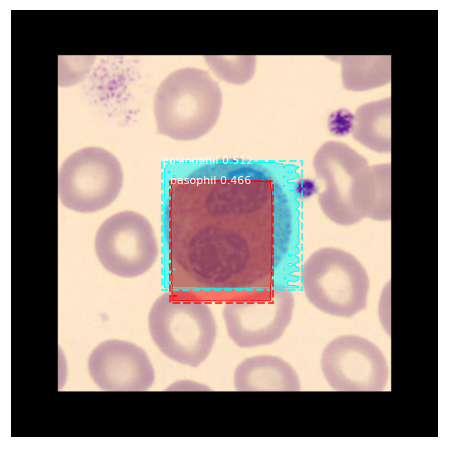

In [30]:
# Test on a random image
dataset_val = BloodDataset()
dataset_val.load_blood("/content/dataset", "val")
dataset_val.prepare()
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                          image_id, use_mini_mask=False)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

r = results[0]
print("True: ", dataset_val.image_reference(image_id).split("_")[0])
print("Prediction")
for c, s in zip(r['class_ids'], r['scores']):
  print(searchKeysByVal(name_dict, c), " ===> ", s)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())